"""  
made by Kataoka @2023/11/XX.  
  
This is tutorial for PINNs and PyTorch.  
Build a model for predicting 2D cavity flow.  
"""  

# Import Libraries

In [1]:
# Standard Library
import os
import sys
import glob
import time
from decimal import Decimal
import matplotlib.pyplot as plt

# External Library
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torchviz import make_dot

# Settings

In [2]:
#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
#device = torch.device("cpu")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Data

In [3]:
def sample_points_cavity(
    num_sampling = 200000,
    num_sampling_left_edge = 10000,
    num_sampling_right_edge = 10000,
    num_sampling_bottom_edge = 10000,
    num_sampling_top_edge = 10000,
    num_sampling_init = 10000,
    continuous_time=True,
    size = 1,
    maxtime = 1,
    dt = 0.1,
    beta = None
):
    """
    docstring
        
    """

    points_dict = {}

    # sampling for continuous time
    if continuous_time==True:
        
        # within the region
        points_dict["residual"] = sample_from_Rectangular(num_sampling=num_sampling, x_size=size, y_size=size, z_size=maxtime)
        
        # boundary
        temp_array = sample_from_Square(num_sampling=num_sampling_left_edge, x_size=size, y_size=maxtime)
        points_dict["left_edge"] = np.concatenate([np.full((num_sampling_left_edge, 0), size), temp_array], axis=1)
        
        temp_array = sample_from_Square(num_sampling=num_sampling_right_edge, x_size=size, y_size=maxtime)
        points_dict["right_edge"] = np.concatenate([np.full((num_sampling_right_edge, 1), size), temp_array], axis=1)
        
        temp_array = sample_from_Square(num_sampling=num_sampling_bottom_edge, x_size=size, y_size=maxtime)
        points_dict["bottom_edge"] = \
            np.concatenate([temp_array[:,0:1], np.full((num_sampling_bottom_edge, 1), 0), temp_array[:,1:2]], axis=1)
        
        temp_array = sample_from_Square(num_sampling=num_sampling_top_edge, x_size=size, y_size=maxtime)
        points_dict["top_edge"] = \
            np.concatenate([temp_array[:,0:1], np.full((num_sampling_top_edge, 1), 0), temp_array[:,1:2]], axis=1)

        # initial
        temp_array = sample_from_Square(num_sampling=num_sampling_init, x_size=size, y_size=size)
        points_dict["init"] = np.concatenate([temp_array, np.full((num_sampling_init, 1), 0)], axis=1)

        
    # sampling for discrete time        
    else:
        maxstep = int(Decimal(str(maxtime))/Decimal(str(dt)))
        
        # correction
        if beta==None:
            beta = maxstep

        num_sampling = int(num_sampling/beta)
        num_sampling_left_edge = int(num_sampling_left_edge/beta)
        num_sampling_right_edge = int(num_sampling_right_edge/beta)
        num_sampling_bottom_edge = int(num_sampling_bottom_edge/beta)
        num_sampling_top_edge = int(num_sampling_top_edge/beta)

        # within the region
        res = sample_from_Square(num_sampling=num_sampling, x_size=size, y_size=size)

        # res and boundary
        temp_array = sample_from_Line(num_sampling=num_sampling_left_edge, x_size=size)
        left_edge = np.concatenate([np.full((num_sampling_left_edge, 1), 0), temp_array], axis=1)

        temp_array = sample_from_Line(num_sampling=num_sampling_right_edge, x_size=size)
        right_edge = np.concatenate([np.full((num_sampling_right_edge, 1), size), temp_array], axis=1)

        temp_array = sample_from_Line(num_sampling=num_sampling_bottom_edge, x_size=size)
        bottom_edge = np.concatenate([temp_array, np.full((num_sampling_bottom_edge, 1), 0)], axis=1)

        temp_array = sample_from_Line(num_sampling=num_sampling_top_edge, x_size=size)
        top_edge = np.concatenate([temp_array, np.full((num_sampling_top_edge, 1), size)], axis=1)

        # initialize dict
        points_dict["res"] = np.concatenate([res, np.full((len(res), 1), dt)], axis=1)
        points_dict["left_edge"] = np.concatenate([left_edge, np.full((len(left_edge), 1), dt)], axis=1)
        points_dict["right_edge"] = np.concatenate([right_edge, np.full((len(right_edge), 1), dt)], axis=1)
        points_dict["bottom_edge"] = np.concatenate([bottom_edge, np.full((len(bottom_edge), 1), dt)], axis=1)
        points_dict["top_edge"] = np.concatenate([top_edge, np.full((len(top_edge), 1), dt)], axis=1)

        for i in range(2, maxstep+1):
            for key,array in zip(list(points_dict.keys()), [res, left_edge, right_edge, bottom_edge, top_edge]):

                points_dict[key] = np.concatenate([points_dict[key], np.concatenate([array, np.full((len(array), 1), i*dt)], axis=1)])

        # initial
        temp_array = np.concatenate([res, left_edge, right_edge, bottom_edge, top_edge], axis=0)
        points_dict["init"] = np.concatenate([temp_array, np.full((len(temp_array), 1), 0)], axis=1)
    
    return points_dict


def sample_points_cavity_steady(
    num_sampling = 3000,
    num_sampling_left_edge = 300,
    num_sampling_right_edge = 300,
    num_sampling_bottom_edge = 300,
    num_sampling_top_edge = 1000,
    size = 1,
):
    """
    docstring
        
    """
    
    points_dict = {}
    
    # within the region
    points_dict["residual"] = sample_from_Square(num_sampling=num_sampling, x_size=size, y_size=size)

    # boundary
    temp_array = sample_from_Line(num_sampling=num_sampling_left_edge, x_size=size)
    points_dict["left_edge"] = np.concatenate([np.full((num_sampling_left_edge, 1), 0), temp_array], axis=1)

    temp_array = sample_from_Line(num_sampling=num_sampling_right_edge, x_size=size)
    points_dict["right_edge"] = np.concatenate([np.full((num_sampling_right_edge, 1), size), temp_array], axis=1)

    temp_array = sample_from_Line(num_sampling=num_sampling_bottom_edge, x_size=size)
    points_dict["bottom_edge"] = np.concatenate([temp_array, np.full((num_sampling_bottom_edge, 1), 0)], axis=1)

    temp_array = sample_from_Line(num_sampling=num_sampling_top_edge, x_size=size)
    points_dict["top_edge"] = np.concatenate([temp_array, np.full((num_sampling_top_edge, 1), size)], axis=1)

    return points_dict


def sample_from_Rectangular(
    num_sampling, 
    x_size,
    y_size,
    z_size,
    x_min = 0,
    y_min = 0,
    z_min = 0
):
    """
    sample points from a recranglar region.
    
    Args:
        num_sampling : int / number of sampling points
        x_size : int or float / rectangular length for x
        y_size : int or float / rectangular length for y
        z_size : int or float / rectangular length for z
        x_min = 0 : int or float / minimum value x of sampling range. sample from [x_min, x_min+x_size]
        y_min = 0 : int or float / minimum value y of sampling range. sample from [y_min, y_min+y_size]
        z_min = 0 : int or float / minimum value z of sampling range. sample from [z_min, z_min+z_size]

    Returns:
        points_array: np.ndarray / set of points
    """
    
    points_array = np.random.rand(num_sampling, 3)
    
    size_array = \
        np.concatenate([np.full((num_sampling, 1),x_size), np.full((num_sampling, 1),y_size), np.full((num_sampling, 1),z_size)], axis=1)
    min_array = \
        np.concatenate([np.full((num_sampling, 1),x_min), np.full((num_sampling, 1),y_min), np.full((num_sampling, 1),z_min)], axis=1)

    return points_array * size_array - min_array


def sample_from_Square(
    num_sampling, 
    x_size,
    y_size,
    x_min = 0,
    y_min = 0,
):
    """
    sample points from a square region.

    Args:
        num_sampling : int / number of sampling points
        x_size : int or float / rectangular length for x
        y_size : int or float / rectangular length for y
        x_min : int or float / minimum value x of sampling range. sample from [x_min, x_min+x_size]
        y_min : int or float / minimum value y of sampling range. sample from [y_min, y_min+y_size]

    Returns:
        points_array: np.ndarray / set of points
    """

    points_array = np.random.rand(num_sampling, 2)
    
    size_array = np.concatenate([np.full((num_sampling, 1),x_size), np.full((num_sampling, 1),y_size)], axis=1)
    min_array = np.concatenate([np.full((num_sampling, 1),x_min), np.full((num_sampling, 1),y_min)], axis=1)

    return points_array * size_array - min_array



def sample_from_Line(
    num_sampling, 
    x_size,
    x_min = 0,
):
    """
    sample points from a line region.

    Args:
        num_sampling : int or float / number of sampling points
        x_size : int or float / rectangular length for x
        x_min : int or float / minimum value x of sampling range. sample from [x_min, x_min+x_size]

    Returns:
        points_array: np.ndarray / set of points
    """
    
    points_array = np.random.rand(num_sampling, 1)
    
    size_array = np.concatenate([np.full((num_sampling, 1),x_size)], axis=1)
    min_array = np.concatenate([np.full((num_sampling, 1),x_min)], axis=1)

    return points_array * size_array - min_array

# Visualization

In [4]:
def plot_residual2D(
    data,
    region_map
):
    """
    docstring
    """
    
    fig = plt.figure(figsize = (6, 6))
    ax = fig.add_subplot(111)
    
    ax.set_xlabel("x", size = 14)
    ax.set_ylabel("y", size = 14)
    
    c_map = ["black", "blue", "green", "red"]
    
    for i,key in enumerate(list(data.keys())):
        ax.scatter(data[key][:,0], data[key][:,1], s=0.1, color=c_map[region_map[i]])
    
    plt.show()
    
    return


def plot_residual3D(
    data,
    region_map
):
    """
    docstring
    """
    
    fig = plt.figure(figsize = (6, 6))
    ax = fig.add_subplot(111, projection="3d")
    
    ax.set_xlabel("x", size = 14)
    ax.set_ylabel("t", size = 14)
    ax.set_zlabel("y", size = 14)
    
    c_map = ["black", "blue", "green", "red"]
    
    for i,key in enumerate(list(data.keys())):
        ax.scatter(data[key][:,0], data[key][:,2], data[key][:,1], s=0.1, color=c_map[region_map[i]])
        
    plt.show()
    
    return


def plot_Vector2D(
    X, Y, U, V, scale=1
):
    """
    docstring
    """
    
    fig = plt.figure(figsize = (8, 6))
    ax = fig.add_subplot(111)
    
    Q = ax.quiver(X, Y, scale*U, scale*V, (U**2+V**2)**0.5, cmap="jet", angles="xy", scale_units="xy", scale=1)
    
    ax.set_xlabel("x", size = 14)
    ax.set_ylabel("y", size = 14)
    ax.set_facecolor("black")
    ax.set_xlim(min(X), max(X))
    ax.set_ylim(min(Y), max(Y))
    ax.set_aspect("equal")
    
    fig.colorbar(Q, label="velocity")
    
    plt.show()
    
    return


def plot_Scalar2D(
    X, Y, img, split=5
):
    """
    docstring
    """
    
    fig = plt.figure(figsize = (8, 6))
    ax = fig.add_subplot(111)
    
    Q = ax.imshow(img, cmap="jet")
    
    X = X.reshape(-1)
    Y = Y.reshape(-1)
    
    height = img.shape[0]
    width = img.shape[1]
    
    ax.set_xlabel("x", size = 14)
    ax.set_ylabel("y", size = 14)
    ax.set_xticks(np.linspace(0, width-1, split+1))
    ax.set_yticks(np.linspace(0, height-1, split+1))
    ax.set_xticklabels(np.round(np.linspace(min(X), max(X), split+1),3))
    ax.set_yticklabels(np.round(np.linspace(min(Y), max(Y), split+1),3)[::-1])

    ax.set_aspect("equal")
    
    fig.colorbar(Q, label="velocity")
    
    plt.show()
    
    return


def plot_Scalar2D_summary(
    X, Y, U, V, P, split=5
):
    """
    docstring
    """
    
    fig = plt.figure(figsize = (18, 4))
    labels = ["velocity_u", "velocity_v", "pressure"]
    
    for i,data in enumerate([U, V, P]):
    
        ax = fig.add_subplot(1,3,i+1)

        Q = ax.imshow(data, cmap="jet")

        X = X.reshape(-1)
        Y = Y.reshape(-1)

        height = data.shape[0]
        width = data.shape[1]

        ax.set_xlabel("x", size = 14)
        ax.set_ylabel("y", size = 14)
        ax.set_xticks(np.linspace(0, width-1, split+1))
        ax.set_yticks(np.linspace(0, height-1, split+1))
        ax.set_xticklabels(np.round(np.linspace(min(X), max(X), split+1),3))
        ax.set_yticklabels(np.round(np.linspace(min(Y), max(Y), split+1),3)[::-1])

        ax.set_aspect("equal")

        fig.colorbar(Q, label=labels[i])
    
    plt.show()
    
    return

# Physics-Informed Neural Networks

In [5]:
class DNN(nn.Module):

    def __init__(self, input_size, output_size, num_layer, num_neuron):
        
        super(DNN, self).__init__()
        
        # Instance Variable
        self.input_size = input_size
        self.output_size = output_size
        self.num_layer = num_layer
        self.num_neuron = num_neuron

        self.inputs = nn.Linear(input_size, num_neuron)
        self.fc1 = nn.Linear(num_neuron, num_neuron)
        self.fc2 = nn.Linear(num_neuron, num_neuron)
        self.fc3 = nn.Linear(num_neuron, num_neuron)
        self.outputs = nn.Linear(num_neuron, output_size)
        
        
        nn.init.xavier_uniform_(self.inputs.weight)
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)
        nn.init.xavier_uniform_(self.outputs.weight)

        
        #self.activation = nn.SiLU()
        self.activation = nn.Tanh()
        
        return

        
    def forward(self, x):
            
        x = self.activation(self.inputs(x))
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.outputs(x)
        
        return x

In [6]:
class PhysicsInformedNN():
    def __init__(self, input_size, output_size, num_layer, num_neuron, X, U, Re):
        
        # Data
        self.x_res = torch.tensor(X["res"][:, 0:1], requires_grad=True).float().to(device)
        self.y_res = torch.tensor(X["res"][:, 1:2], requires_grad=True).float().to(device)
        
        self.x_bound = torch.tensor(X["bound"][:, 0:1], requires_grad=True).float().to(device)
        self.y_bound = torch.tensor(X["bound"][:, 1:2], requires_grad=True).float().to(device)
        self.u_bound = torch.tensor(U["bound"][:, 0:1]).float().to(device)
        self.v_bound = torch.tensor(U["bound"][:, 1:2]).float().to(device)
        
        # Reynolds Number
        self.Re = Re
        
        # Loss History
        self.loss_history = {"bound": [], "res": [], "total": []}
        
        # Deep Neural Networks
        self.dnn = DNN(input_size, output_size, num_layer, num_neuron).to(device)
        self.optimizer = torch.optim.LBFGS(self.dnn.parameters(), lr=1, max_iter=10)
        
        
    def net_u(self, x, y):  
        
        outputs = self.dnn(torch.cat([x, y], dim=1).to(device))
        u = outputs[:, 0:1]
        v = outputs[:, 1:2]
        p = outputs[:, 2:3]
        
        return u, v, p

    
    def net_f(self, x, y):

        u, v, p = self.net_u(x, y)

        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), retain_graph=True, create_graph=True)[0]
        u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), retain_graph=True, create_graph=True)[0]

        v_x = torch.autograd.grad(v, x, grad_outputs=torch.ones_like(v), retain_graph=True, create_graph=True)[0]
        v_xx = torch.autograd.grad(v_x, x, grad_outputs=torch.ones_like(v_x), retain_graph=True, create_graph=True)[0]
        v_y = torch.autograd.grad(v, y, grad_outputs=torch.ones_like(v), retain_graph=True, create_graph=True)[0]
        v_yy = torch.autograd.grad(v_y, y, grad_outputs=torch.ones_like(v_y), retain_graph=True, create_graph=True)[0]
        
        p_x = torch.autograd.grad(p, x, grad_outputs=torch.ones_like(p), retain_graph=True, create_graph=True)[0]
        p_y = torch.autograd.grad(p, y, grad_outputs=torch.ones_like(p), retain_graph=True, create_graph=True)[0]        
        
        f_x = u * u_x + v * u_y + p_x - 1/self.Re * (u_xx + u_yy)
        f_y = u * v_x + v * v_y + p_y - 1/self.Re * (v_xx + v_yy)
        f_continue = u_x + v_y
        
        return f_x, f_y, f_continue
    
    
    def train(self, nIter, record=100):
        
        self.dnn.train()
        
        # Initial Loss
        u_pred_bound, v_pred_bound, p_pred_bound = self.net_u(self.x_bound, self.y_bound)
        f_pred_x, f_pred_y, f_pred_continue = self.net_f(self.x_res, self.y_res)

        bound_loss_noslip = torch.mean((self.u_bound[:1500] - u_pred_bound[:1500]) ** 2) + torch.mean((self.v_bound[:1500] - v_pred_bound[:1500]) ** 2)
        bound_loss_top = torch.mean((1.0 - 2.0 * torch.abs(self.x_bound[1500:]-0.5)) * (self.u_bound[1500:] - u_pred_bound[1500:]) ** 2) + torch.mean((self.v_bound[1500:] - v_pred_bound[1500:]) ** 2)
        bound_loss = bound_loss_top + bound_loss_noslip

        res_loss = torch.mean(f_pred_x ** 2 + f_pred_y ** 2 + f_pred_continue ** 2)

        loss = bound_loss + res_loss
        
        print(
            "Epoch: 0, boundary_Loss: %.6f, residual_Loss: %.6f, total_loss: %.6f" % 
            (
                bound_loss.item(), 
                res_loss.item(), 
                loss.item()
            )
        )
        
        # Training
        for epoch in range(1, nIter+1):
            
            def closure():
                self.optimizer.zero_grad()
                
                u_pred_bound, v_pred_bound, p_pred_bound = self.net_u(self.x_bound, self.y_bound)
                f_pred_x, f_pred_y, f_pred_continue = self.net_f(self.x_res, self.y_res)

                bound_loss_noslip = torch.mean((self.u_bound[:1500] - u_pred_bound[:1500]) ** 2) + torch.mean((self.v_bound[:1500] - v_pred_bound[:1500]) ** 2)
                bound_loss_top = torch.mean((1.0 - 2.0 * torch.abs(self.x_bound[1500:]-0.5)) * (self.u_bound[1500:] - u_pred_bound[1500:]) ** 2) + torch.mean((self.v_bound[1500:] - v_pred_bound[1500:]) ** 2)
                bound_loss = bound_loss_top + bound_loss_noslip
                
                res_loss = torch.mean(f_pred_x ** 2 + f_pred_y ** 2 + f_pred_continue ** 2)
                
                loss = bound_loss + res_loss

                loss.backward()
                
                return loss
            
            self.optimizer.step(closure)
            
            # calculate the loss again for monitoring
            u_pred_bound, v_pred_bound, p_pred_bound = self.net_u(self.x_bound, self.y_bound)
            f_pred_x, f_pred_y, f_pred_continue = self.net_f(self.x_res, self.y_res)

            bound_loss_noslip = torch.mean((self.u_bound[:1500] - u_pred_bound[:1500]) ** 2) + torch.mean((self.v_bound[:1500] - v_pred_bound[:1500]) ** 2)
            bound_loss_top = torch.mean((1.0 - 2.0 * torch.abs(self.x_bound[1500:]-0.5)) * (self.u_bound[1500:] - u_pred_bound[1500:]) ** 2) + torch.mean((self.v_bound[1500:] - v_pred_bound[1500:]) ** 2)
            bound_loss = bound_loss_top + bound_loss_noslip

            res_loss = torch.mean(f_pred_x ** 2 + f_pred_y ** 2 + f_pred_continue ** 2)

            loss = bound_loss + res_loss
            
            # Output display & Record history
            if epoch%record==0:
                print(
                    "Epoch: %d, boundary_Loss: %.6f, residual_Loss: %.6f, total_loss: %.6f" % 
                    (
                        epoch, 
                        bound_loss.item(), 
                        res_loss.item(), 
                        loss.item()
                    )
                )
                
                self.loss_history["bound"].append(loss.item())
                self.loss_history["res"].append(res_loss.item())
                self.loss_history["total"].append(bound_loss.item())
            
            
    def predict(self, X):
        x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        y = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)

        self.dnn.eval()
        u, v, p = self.net_u(x, y)
        u = u.detach().cpu().numpy()
        v = v.detach().cpu().numpy()
        p = p.detach().cpu().numpy()
        
        return u, v, p

# Main

In [7]:
# Representative Value
rep_length = 0.1
rep_velocity = 1.0
rep_kinematic_viscosity = 0.01

Re = (rep_length * rep_velocity) / rep_kinematic_viscosity


# Sampling residual points
residual_points = sample_points_cavity_steady(
                                                num_sampling = 7000,
                                                num_sampling_left_edge = 500,
                                                num_sampling_right_edge = 500,
                                                num_sampling_bottom_edge = 500,
                                                num_sampling_top_edge = 1500,
                                                size = 1,
                                            )

# Reshape array
X = {}
#X["res"] = residual_points["residual"]
X["res"] = np.empty(shape=(0,2))
for key in list(residual_points.keys()):
    X["res"] = np.concatenate([X["res"], residual_points[key]], axis=0)
X["bound"] = np.empty(shape=(0,2))
for key in ["left_edge", "right_edge", "bottom_edge", "top_edge"]:
    X["bound"] = np.concatenate([X["bound"], residual_points[key]], axis=0)


U = {}
U["bound"] = np.empty(shape=(0,2))
for key in ["left_edge", "right_edge", "bottom_edge"]:
    u_bound = np.full((len(residual_points[key]), 1), 0)
    v_bound = np.full((len(residual_points[key]), 1), 0)
    U_bound = np.concatenate([u_bound, v_bound], axis=1)
    U["bound"] = np.concatenate([U["bound"], U_bound], axis=0)

u_bound = np.full((len(residual_points["top_edge"]), 1), 1) #- 20.0 * abs(residual_points["top_edge"][:,0:1])
v_bound = np.full((len(residual_points["top_edge"]), 1), 0)
U_bound = np.concatenate([u_bound, v_bound], axis=1)
U["bound"] = np.concatenate([U["bound"], U_bound], axis=0)

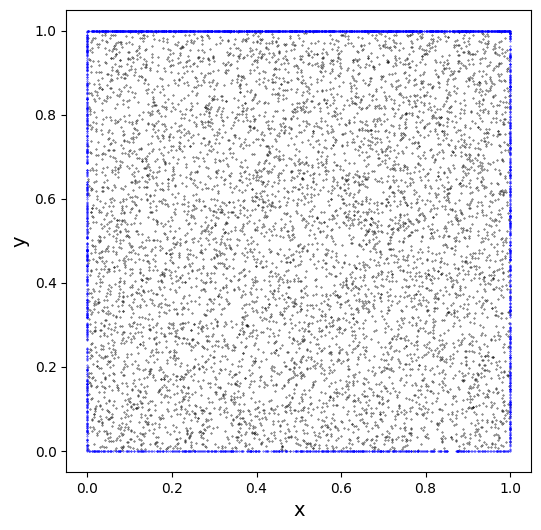

In [8]:
plot_residual2D(residual_points, [0,1,1,1,1])

In [9]:
# NN parameters
input_size = 2
output_size = 3
num_layer = 4
num_neuron = 50

model = PhysicsInformedNN(input_size, output_size, num_layer, num_neuron, X, U, Re)

In [10]:
# Training

start = time.time()

model.train(nIter=2000, record=50)

end = time.time()

Epoch: 0, boundary_Loss: 2.025616, residual_Loss: 0.153565, total_loss: 2.179181
Epoch: 50, boundary_Loss: 0.021123, residual_Loss: 0.001450, total_loss: 0.022573
Epoch: 100, boundary_Loss: 0.009429, residual_Loss: 0.002014, total_loss: 0.011444
Epoch: 150, boundary_Loss: 0.005392, residual_Loss: 0.001139, total_loss: 0.006531
Epoch: 200, boundary_Loss: 0.004400, residual_Loss: 0.000799, total_loss: 0.005198
Epoch: 250, boundary_Loss: 0.003628, residual_Loss: 0.000745, total_loss: 0.004373
Epoch: 300, boundary_Loss: 0.003137, residual_Loss: 0.000632, total_loss: 0.003769
Epoch: 350, boundary_Loss: 0.002816, residual_Loss: 0.000513, total_loss: 0.003329
Epoch: 400, boundary_Loss: 0.002468, residual_Loss: 0.000485, total_loss: 0.002953
Epoch: 450, boundary_Loss: 0.002245, residual_Loss: 0.000436, total_loss: 0.002681
Epoch: 500, boundary_Loss: 0.002047, residual_Loss: 0.000429, total_loss: 0.002476
Epoch: 550, boundary_Loss: 0.001931, residual_Loss: 0.000382, total_loss: 0.002313
Epoch: 

In [11]:
end - start

600.6239633560181

In [12]:
x = np.linspace(0.0, 1.0, 30)
y = np.linspace(0.0, 1.0, 30)
X_, Y_ = np.meshgrid(x, y)

temp = np.concatenate([X_.reshape((-1,1)),Y_.reshape((-1,1))], axis=1)
u, v, p = model.predict(temp)

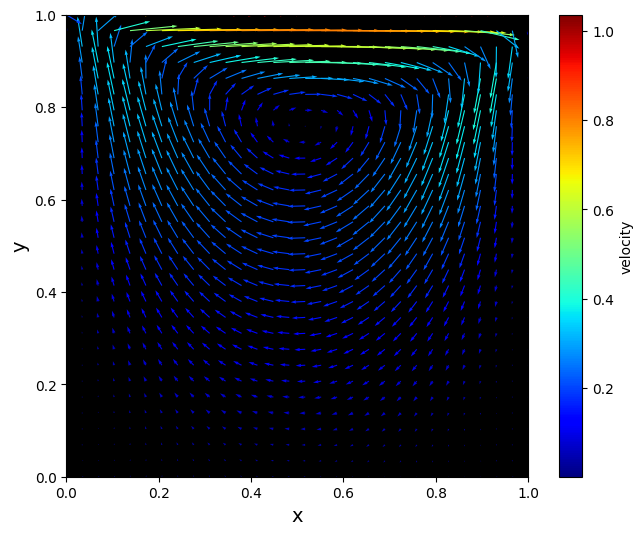

In [13]:
plot_Vector2D(X_.reshape((-1,1)), Y_.reshape((-1,1)), u, v, scale=0.2)

In [14]:
x = np.linspace(0, 1, 500)
y = np.linspace(0, 1, 500)
X_, Y_ = np.meshgrid(x, y)

temp = np.concatenate([X_.reshape((-1,1)),Y_.reshape((-1,1))], axis=1)
u, v, p = model.predict(temp)

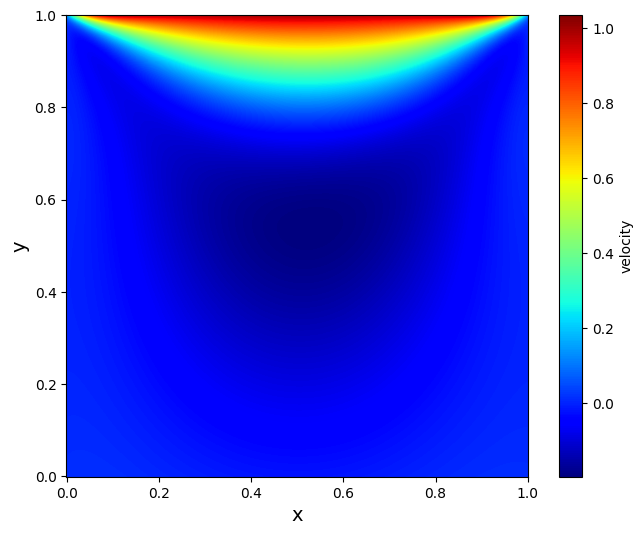

In [15]:
plot_Scalar2D(X_, Y_, np.flipud(u.reshape((500,500))))

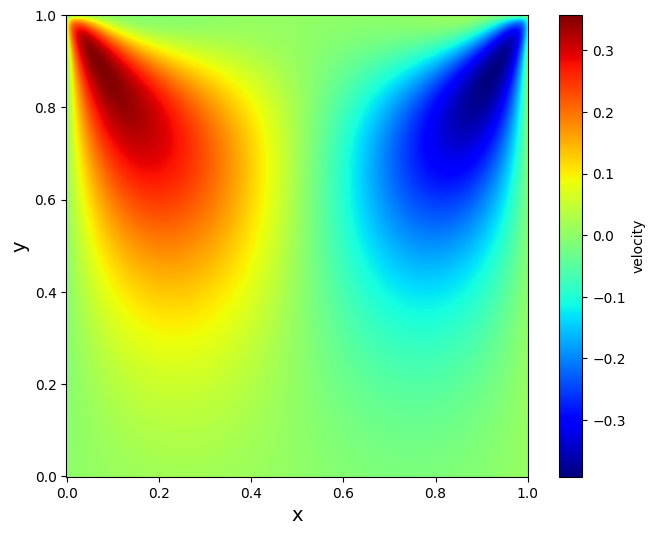

In [16]:
plot_Scalar2D(X_, Y_, np.flipud(v.reshape((500,500))))

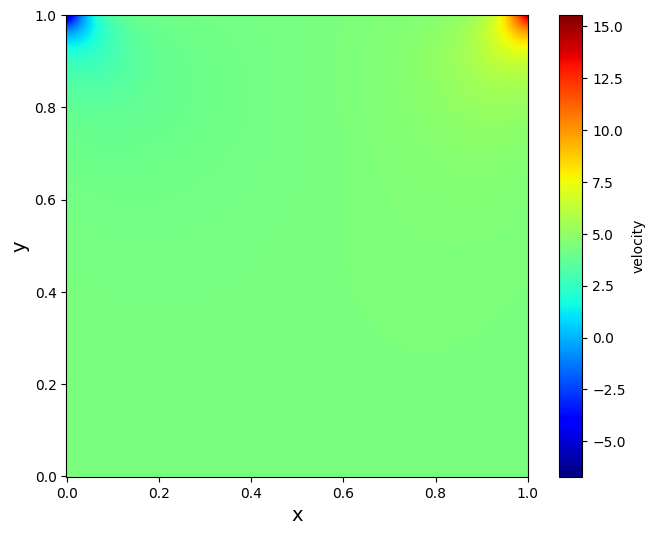

In [17]:
plot_Scalar2D(X_, Y_, np.flipud(p.reshape((500,500))))

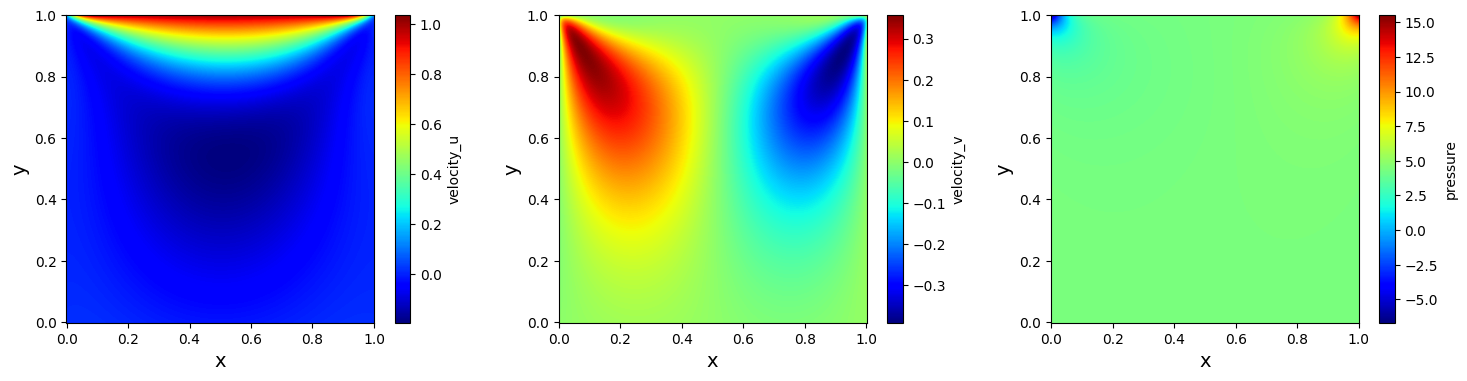

In [18]:
plot_Scalar2D_summary(X_, Y_, np.flipud(u.reshape((500,500))), np.flipud(v.reshape((500,500))), np.flipud(p.reshape((500,500))))

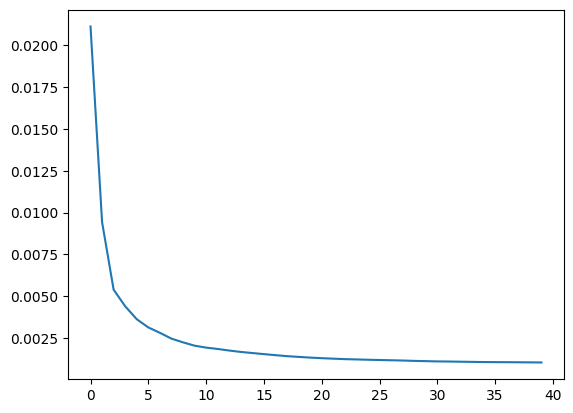

In [19]:
plt.plot(model.loss_history["total"])

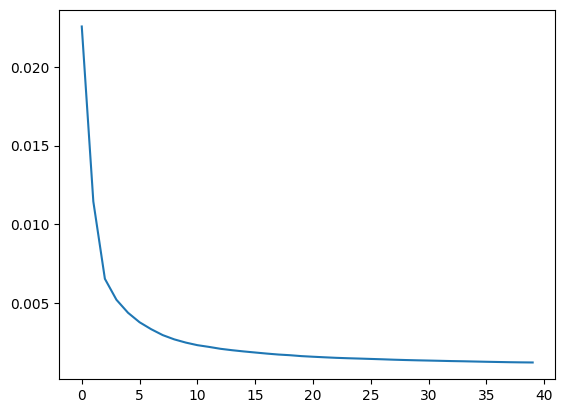

In [20]:
plt.plot(model.loss_history["bound"])

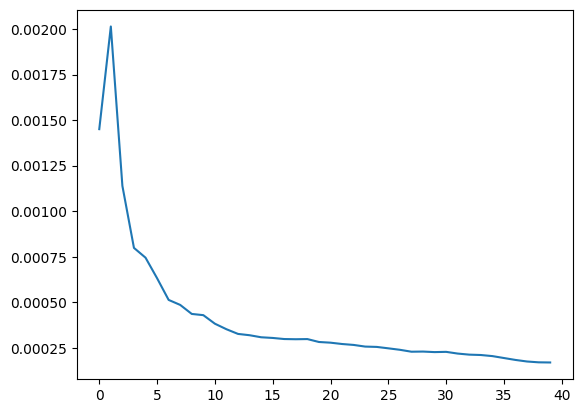

In [21]:
plt.plot(model.loss_history["res"])

# Industrial Waste

In [22]:
def sample_from_Rectangular(
    num_sampling, 
    x_size,
    y_size,
    z_size,
    x_min = 0,
    y_min = 0,
    z_min = 0
):
    """
    sample points from recranglar region.
    
    Args:
        num_sampling : int / number of sampling points
        x_size : int or float / rectangular length for x
        y_size : int or float / rectangular length for y
        z_size : int or float / rectangular length for z
        x_min = 0 : int or float / minimum value of x sampling range. sample from [x_min, x_min+x_size]
        y_min = 0 : int or float / minimum value of y sampling range. sample from [y_min, y_min+y_size]
        z_min = 0 : int or float / minimum value of z sampling range. sample from [z_min, z_min+z_size]

    Returns:
        points_array: np.ndarray / set of points
    """

    
    points_array = np.empty(shape=(0,3))

    for i in range(num_sampling):
        new_data = np.random.rand(1,3) * np.array([[x_size, y_size, z_size]]) - np.array([[x_min, y_min, z_min]])
        points_array = np.concatenate([points_array, new_data], axis=0)

    return points_array



def sample_from_Square(
    num_sampling, 
    x_size,
    y_size,
    x_min = 0,
    y_min = 0,
):
    """
    sample points from square region.

    Args:
        num_sampling : int / number of sampling points
        x_size : int or float / rectangular length for x
        y_size : int or float / rectangular length for y
        x_min : int or float / minimum value of x sampling range. sample from [x_min, x_min+x_size]
        y_min : int or float / minimum value of y sampling range. sample from [y_min, y_min+y_size]

    Returns:
        points_array: np.ndarray / set of points
    """

    
    points_array = np.empty(shape=(0,2))

    for i in range(num_sampling):
        new_data = np.random.rand(1,2) * np.array([[x_size, y_size]]) - np.array([[x_min, y_min]])
        points_array = np.concatenate([points_array, new_data], axis=0)

    return points_array



def sample_from_Line(
    num_sampling, 
    x_size,
    x_min = 0,
):
    """
    sample points from line region.

    Args:
        num_sampling : int or float / number of sampling points
        x_size : int or float / rectangular length for x
        x_min : int or float / minimum value of x sampling range. sample from [x_min, x_min+x_size]

    Returns:
        points_array: np.ndarray / set of points
    """

    
    points_array = np.empty(shape=(0,1))

    for i in range(num_sampling):
        new_data = np.random.rand(1,1) * np.array([[x_size]]) - np.array([[x_min]])
        points_array = np.concatenate([points_array, new_data], axis=0)

    return points_array